In [26]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import skimage.io as skio
from skimage.transform import resize
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import random
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import xml.etree.ElementTree as ET 
import cv2
import scipy

In [ ]:
# mount google drive and zip the data file from there 
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/ibug_300W_large_face_landmark_dataset.zip'

In [34]:
# example code given to load data
tree = ET.parse('/content/labels_ibug_300W_train.xml')
root = tree.getroot()

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(filename.attrib['file'])
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 

In [35]:
class FaceKeypointPixelwiseDataset(Dataset):

    def __init__(self, images, landmarks, boxes, transform=None):
        self.images_filename = images
        self.landmarks = landmarks
        self.boxes = boxes
        self.transform = transform
        
    def __len__(self):
        return len(self.images_filename)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = skio.imread(self.images_filename[idx], as_gray=True)
        landmark = self.landmarks[idx]
        box = self.boxes[idx]
        # enlarge the bonding box, skip the image if its keypoints are still out of box
        left = max(0, box[0])
        top = max(0, box[1])
        left *= 0.7
        top *= 0.7
        width = box[2] * 1.5
        height = box[3] * 1.5
        if not all(landmark[:, 0] > left) or not all(landmark[:, 0] < left + width) or not all(landmark[:, 1] > top) or not all(landmark[:, 1] < top + height):
          return None

        sample = {"image": image, "landmarks": landmark, "box": np.array([left, top, width, height]).astype('float32')}

        if self.transform:
            sample = self.transform(sample)

        return sample

# crop the image by the bonding box given and update the landmarks
class Cropping(object):
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        left, top, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        # handle negative bonding box values
        left = max(0, left)
        top = max(0, top)
        
        image_cropped = image[top:top+h, left:left+w]

        landmarks_cropped = landmarks.copy()
        landmarks_cropped -= [left, top]

        box = np.array([left, top, w, h]).astype('float32')
        return {"image": image_cropped, "landmarks": landmarks_cropped, "box": box}

# resize the image and update the landmarks
class Resize(object):
    def __init__(self, h, w):
        self.height = h
        self.width = w
    
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        h, w = image.shape[:2]

        landmarks[:, 0] *= self.width / w
        landmarks[:, 1] *= self.height / h

        image_resized = resize(image, (self.height, self.width))
        return {"image": image_resized, "landmarks": landmarks, "box": box}

# normalize the image pixel values
class Normalize(object):
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        image_normalized = image.astype('float32') / 255 - 0.5  
        return {"image": image_normalized, "landmarks": landmarks, "box": box}

# create heatmap for each keypoint
class Heatmap(object):
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        N = 9
        one_d_gaussian = cv2.getGaussianKernel(N, 3.0)
        two_d_gaussian = np.outer(one_d_gaussian, one_d_gaussian.T)
        center =  two_d_gaussian[N//2][N//2]
        two_d_gaussian *= (1 / center)
        heatmaps = []
        for row in landmarks:
          new_heatmap = np.zeros_like(image)
          r, c = int(row[1]), int(row[0])
          h_start = max(0, r - N//2)
          h_end = min(224, r + N//2 + 1)
          v_start = max(0, c - N//2)
          v_end = min(224, c + N//2 + 1)

          new_heatmap[h_start:h_end,v_start:v_end] = two_d_gaussian[N//2-(r-h_start):N//2+(h_end-r),
                                                                    N//2-(c-v_start):N//2+(v_end-c)]
          heatmaps.append(new_heatmap)

        heatmaps = np.array(heatmaps).astype('float32')

        return {"image": image, "landmarks": landmarks, "box": box, "heatmaps": heatmaps}

# collate func to filter None value (the image we skip)
def collate_fn(batch):
      batch = list(filter(lambda x: x is not None, batch))
      return torch.utils.data.dataloader.default_collate(batch)


In [36]:
# set the seed for randomness
torch.manual_seed(1205)
random.seed(1205)

training_num = int(0.8 * len(img_filenames))
ts = transforms.Compose([Cropping(), Resize(224, 224), Normalize(), Heatmap()])
training_dataset = FaceKeypointPixelwiseDataset(img_filenames[:training_num], landmarks[:training_num], bboxes[:training_num], transform=ts)
validation_dataset = FaceKeypointPixelwiseDataset(img_filenames[training_num:], landmarks[training_num:], bboxes[training_num:], transform=ts)

# create dataloaders, using batch size of 16
BATCH_SIZE = 16
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle = True, num_workers = 2, collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle = True, num_workers = 2, collate_fn=collate_fn)

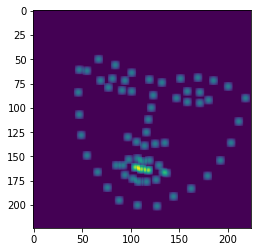

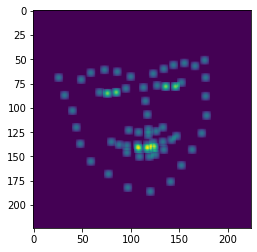

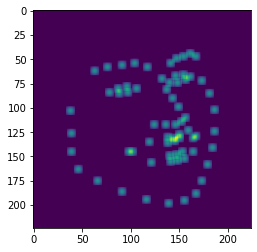

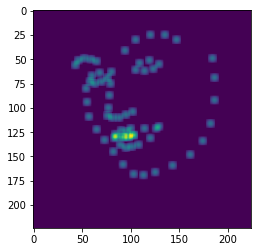

In [37]:
# sampled the first 4 images with its accumulated heatmaps of all landmarks
cnt = 0
for i, sample_batched in enumerate(training_dataloader):
  images, heatmaps_batched = sample_batched["image"], sample_batched["heatmaps"]
  
  for j in range(images.shape[0]):
    heatmap = heatmaps_batched[j]
    image = images[j]
    heatmap_acc = np.zeros((224, 224))
    for h in heatmap:
      heatmap_acc += h.numpy()
    
    plt.figure()
    plt.imshow(heatmap_acc)
    plt.savefig("/sampled_heatmap{}.jpg".format(j + 1))

    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.savefig("/sampled_img_heatmap{}.jpg".format(j + 1))
    plt.close()

    cnt += 1
    if cnt == 4:
      break
  if cnt == 4:
    break

In [38]:
# modify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

# import pretrained fcn_resnet50 as suggested and modify the first and the last layer
fcn = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
fcn.backbone.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
fcn.classifier[4] = nn.Conv2d(512, 68, 1, 1)
fcn.aux_classifier[4] = nn.Conv2d(256, 68, 1, 1)
fcn = fcn.to(device)
print(fcn)

Using device cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [39]:
# set parameters
lr = 0.0001
epochs = 12

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(fcn.parameters(), lr=lr, weight_decay=5e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

training_loss = []
validation_loss = []

fcn.train()
for epoch in range(epochs):
  losses = []
  for sample_batched in training_dataloader:
    optimizer.zero_grad()
    x, y = sample_batched["image"].to(device), sample_batched["heatmaps"].to(device)
    x = x.unsqueeze(1)
    pred = fcn(x)['out']
    pred = torch.reshape(pred, (pred.shape[0], 68, 224, 224))
    loss = criterion(pred, y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
  training_loss.append(np.mean(losses))
  scheduler.step()

  # evaluate validation loss
  with torch.no_grad():
    fcn.eval()

    losses = []
    for sample_batched in validation_dataloader:
        x, y = sample_batched["image"].to(device), sample_batched["heatmaps"].to(device)
        x = x.unsqueeze(1)
        pred = fcn(x)['out']
        pred = torch.reshape(pred, (pred.shape[0], 68, 224, 224))
        loss = criterion(pred, y)
        losses.append(loss.item())
    validation_loss.append(np.mean(losses))
    fcn.train()
  print("epoch{} finished, training_loss: {}, validation_loss: {}.".format(epoch + 1, training_loss[epoch], validation_loss[epoch]))

epoch1 finished, training_loss: 0.001222695333082898, validation_loss: 0.000520491870009296.
epoch2 finished, training_loss: 0.0005843093636875113, validation_loss: 0.0005466750423823084.
epoch3 finished, training_loss: 0.0005417135953666185, validation_loss: 0.00046566520142646154.
epoch4 finished, training_loss: 0.00050447681973811, validation_loss: 0.0005117945547681302.
epoch5 finished, training_loss: 0.00046050146842183, validation_loss: 0.0005031418823775658.
epoch6 finished, training_loss: 0.0004465982260762485, validation_loss: 0.00039750466766279367.
epoch7 finished, training_loss: 0.00042364342747434615, validation_loss: 0.0003890116211204302.
epoch8 finished, training_loss: 0.0004073655199500715, validation_loss: 0.00038869157287990674.
epoch9 finished, training_loss: 0.00039258058438032957, validation_loss: 0.00042799477731542926.
epoch10 finished, training_loss: 0.00038768498732047544, validation_loss: 0.00036589103997574144.
epoch11 finished, training_loss: 0.000371499195

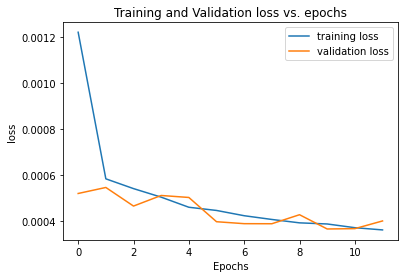

In [40]:
# plot the training and validation loss
plt.figure()
plt.plot(range(epochs), training_loss, label="training loss")
plt.plot(range(epochs), validation_loss, label="validation loss")
plt.title("Training and Validation loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig("/part4_loss.jpg")

In [41]:
# save the model
torch.save(fcn.state_dict(), "/fcn_for_part4.pt")

In [77]:
# Dateset and helper functions for test dataset: remove landmarks and heatmaps fields
class FaceKeypointPixelwiseTestDataset(Dataset):

    def __init__(self, images, boxes, transform=None):
        self.images_filename = images
        self.boxes = boxes
        self.transform = transform
        
    def __len__(self):
        return len(self.images_filename)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = skio.imread(self.images_filename[idx], as_gray=True)
        box = self.boxes[idx]

        sample = {"image": image, "box": box, "filename": self.images_filename[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

class CroppingTest(object):
    def __call__(self, sample):
        image, box, f = sample["image"], sample["box"], sample["filename"]
        im_h, im_w = image.shape[:2]
        left, top, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        # handle negative box
        left = max(0, left)
        top = max(0, top)

        image_cropped = image[top:top+h, left:left+w]

        return {"image": image_cropped, "box": box, "filename": f}

class ResizeTest(object):
    def __init__(self, h, w):
        self.height = h
        self.width = w
    
    def __call__(self, sample):
        image, box, f = sample["image"], sample["box"], sample["filename"]
        h, w = image.shape[:2]

        image_resized = resize(image, (self.height, self.width))
        return {"image": image_resized, "box": box, "filename": f}


class NormalizeTest(object):
    def __call__(self, sample):
        image, box, f = sample["image"], sample["box"], sample["filename"]
        image_normalized = image.astype(np.float32) / 255 - 0.5  
        return {"image": image_normalized, "box": box, "filename": f}

In [78]:
!wget https://inst.eecs.berkeley.edu/~cs194-26/fa22/hw/proj5/labels_ibug_300W_test_parsed.xml

--2022-11-13 08:03:27--  https://inst.eecs.berkeley.edu/~cs194-26/fa22/hw/proj5/labels_ibug_300W_test_parsed.xml
Resolving inst.eecs.berkeley.edu (inst.eecs.berkeley.edu)... 128.32.42.199
Connecting to inst.eecs.berkeley.edu (inst.eecs.berkeley.edu)|128.32.42.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131719 (129K) [text/xml]
Saving to: ‘labels_ibug_300W_test_parsed.xml.3’

labels_ibug_300W_te 100%[===================>] 128.63K   845KB/s    in 0.2s    

2022-11-13 08:03:28 (845 KB/s) - ‘labels_ibug_300W_test_parsed.xml.3’ saved [131719/131719]



In [75]:
# example code given to load data
tree = ET.parse('labels_ibug_300W_test_parsed.xml')
root = tree.getroot()

bboxes = [] # face bounding box used to crop the image
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(filename.attrib['file'])
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 
   
bboxes = np.array(bboxes).astype('float32') 

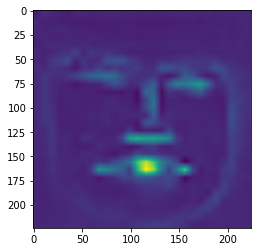

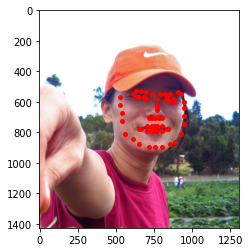

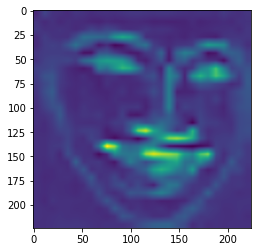

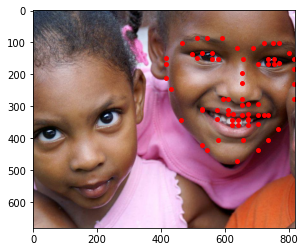

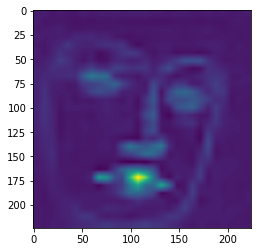

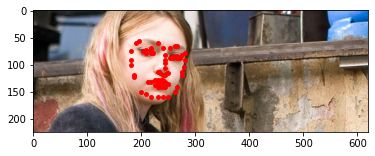

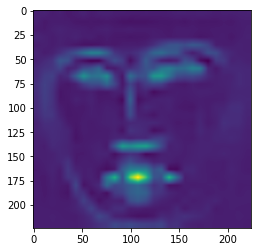

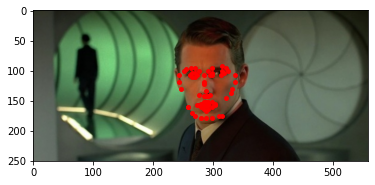

In [80]:
# crop and resize the images in test dataset
ts = transforms.Compose([CroppingTest(), ResizeTest(224, 224), NormalizeTest()])
test_dataset = FaceKeypointPixelwiseTestDataset(img_filenames, bboxes, transform=ts)

# create dataloaders, using batch size of 16
BATCH_SIZE =  16
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = False)

# visualize some images in test dataset with the prediction
with torch.no_grad():
  fcn.eval()
  for i, sample_batched in enumerate(test_dataloader):
    # apply it on images in second batch so that they're different from the ones in part 3
    if i == 1:
      x = sample_batched["image"].to(device)
      x = x.unsqueeze(1)
      pred = fcn(x)['out']
      pred = torch.reshape(pred, (pred.shape[0], 68, 224, 224))
        
      for j in range(4):
        heatmaps = pred.cpu().detach()[j]
        image = sample_batched["image"][j]
        f = sample_batched["filename"][j]
        landmarks = []
        h_a = np.zeros((224, 224))
        for h in heatmaps:
          h = h.numpy()
          h_a += h

          s = 0
          x = 0
          y = 0

          # compute the weighted avg of top 15 maximum points
          for n in range(15):
            pos = h.argmax()
            r = pos // 224
            c = pos % 224
            h_value = h[r][c]
            x += c * h_value
            y += r * h_value
            s += h_value

          landmarks.append([x / s, y / s])

        landmarks = np.array(landmarks)

        # plot output heatmap
        plt.figure()
        plt.imshow(h_a)
        plt.savefig("/test_heatmap{}.jpg".format(j + 1))

        # plot keypoints predicted in cropped image
        plt.figure()
        plt.imshow(image, cmap="gray")
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 15, c="red")
        plt.savefig("/test_part4_cropped{}.jpg".format(j + 1))
        plt.close()

        # plot keypoints predicted on original image
        landmarks_origin = landmarks
        box = sample_batched["box"][j]
        im_origin = skio.imread(f)
        left = max(0, int(box[0]))
        top = max(0, int(box[1]))
        width = int(box[2])
        height = int(box[3])

        landmarks_origin[:, 0] *= width / 224
        landmarks_origin[:, 1] *= height / 224

        landmarks_origin += [left, top]
        plt.figure()
        plt.imshow(im_origin)
        plt.scatter(landmarks_origin[:, 0], landmarks_origin[:, 1], s = 15, c="red")
        plt.savefig("/test_part4_original{}.jpg".format(j + 1))
    
    if i == 1:
      break

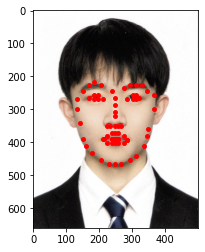

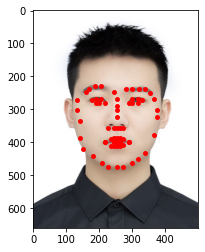

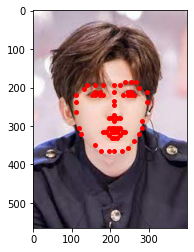

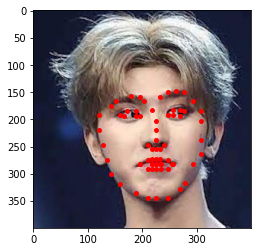

In [66]:
# apply the model on some images in my own collection
my_img_filenames = ["/mypicture.jpg", "/myfriend.jpg", "/idol1.jpg", "/idol2.jpg"]
bboxes = np.array([[120., 190., 250., 290.], [120., 180., 260., 300.], [100., 130., 200., 240.], [110., 100., 210., 250.]]).astype(np.float32)

# crop and resize the images in my dataset
ts = transforms.Compose([CroppingTest(), ResizeTest(224, 224), NormalizeTest()])
my_dataset = FaceKeypointPixelwiseTestDataset(my_img_filenames, bboxes, transform=ts)
# create dataloaders, using batch size of 4
BATCH_SIZE = 4
my_dataloader = DataLoader(my_dataset, batch_size=BATCH_SIZE, shuffle = False)

with torch.no_grad():
  fcn.eval()
  for sample_batched in my_dataloader:
    x = sample_batched["image"].to(device)
    x = x.unsqueeze(1)
    pred = fcn(x)['out']
    pred = torch.reshape(pred, (pred.shape[0], 68, 224, 224))
    for j in range(4):
      heatmaps = pred.cpu().detach()[j]
      image = sample_batched["image"][j]
      landmarks = []
      for h in heatmaps:
        h = h.numpy()
        s = 0
        x = 0
        y = 0
        # compute the weighted avg of top 15 maximum points
        for n in range(15):
          pos = h.argmax()
          r = pos // 224
          c = pos % 224
          h_value = h[r][c]
          x += c * h_value
          y += r * h_value
          s += h_value

        landmarks.append([x / s, y / s])

      landmarks = np.array(landmarks)

      # plot keypoints predicted on original image
      landmarks_origin = landmarks
      box = sample_batched["box"][j]
      im_origin = skio.imread(my_img_filenames[j])
      left = max(0, int(box[0]))
      top = max(0, int(box[1]))
      width = int(box[2])
      height = int(box[3])

      landmarks_origin[:, 0] *= width / 224
      landmarks_origin[:, 1] *= height / 224

      landmarks_origin += [left, top]
      plt.figure()
      plt.imshow(im_origin)
      plt.scatter(landmarks_origin[:, 0], landmarks_origin[:, 1], s = 15, c="red")
      plt.savefig("/my_img_origin_part4_{}.jpg".format(j + 1))
    